## janesick_nature_comms_2023, scRNA

In [6]:
import time
from pathlib import Path
proj_name = "janesick_nc_2023_dev"
save_dir = f"../save/dev_{proj_name}-{time.strftime('%b%d')}/"
save_dir = Path(save_dir)
save_dir.mkdir(parents=True, exist_ok=True)

data_dir = f"../data/janesick_nature_comms_2023/"
data_dir = Path(data_dir)

file_suffix = f"{time.strftime('%b%d-%H%M')}"
file_suffix

'Jun05-2123'

### 3prime

In [1]:
import scanpy as sc
import pandas as pd

from pathlib import Path
p3_path = Path("../data/janesick_nature_comms_2023/scRNA_p3/").expanduser()

# Load data
p3_adata = sc.read_10x_h5(p3_path / "SC3pv3_GEX_Breast_Cancer_DTC_Aggr_count_filtered_feature_bc_matrix.h5")


/opt/anaconda3/envs/concord/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/envs/concord/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [ ]:
# Normalize visium_adata
p3_adata.layers['counts'] = p3_adata.X.copy()
sc.pp.normalize_total(p3_adata, target_sum=1e4)
# log transform
sc.pp.log1p(p3_adata)
# PCA and UMAP
n_latent = 30
sc.pp.pca(p3_adata, n_comps=n_latent, svd_solver='arpack')
sc.pp.neighbors(p3_adata, n_neighbors=15, n_pcs=n_latent)
sc.tl.umap(p3_adata, min_dist=0.1, n_components=2)
sc.tl.leiden(p3_adata, resolution=0.5, key_added='leiden', random_state=42)

/opt/anaconda3/envs/concord/lib/python3.12/site-packages/sklearn/utils/sparsefuncs.py:736: RuntimeWarning: divide by zero encountered in matmul
  matvec=lambda x: X @ x - offset @ x,
/opt/anaconda3/envs/concord/lib/python3.12/site-packages/sklearn/utils/sparsefuncs.py:736: RuntimeWarning: overflow encountered in matmul
  matvec=lambda x: X @ x - offset @ x,
/opt/anaconda3/envs/concord/lib/python3.12/site-packages/sklearn/utils/sparsefuncs.py:736: RuntimeWarning: invalid value encountered in matmul
  matvec=lambda x: X @ x - offset @ x,
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


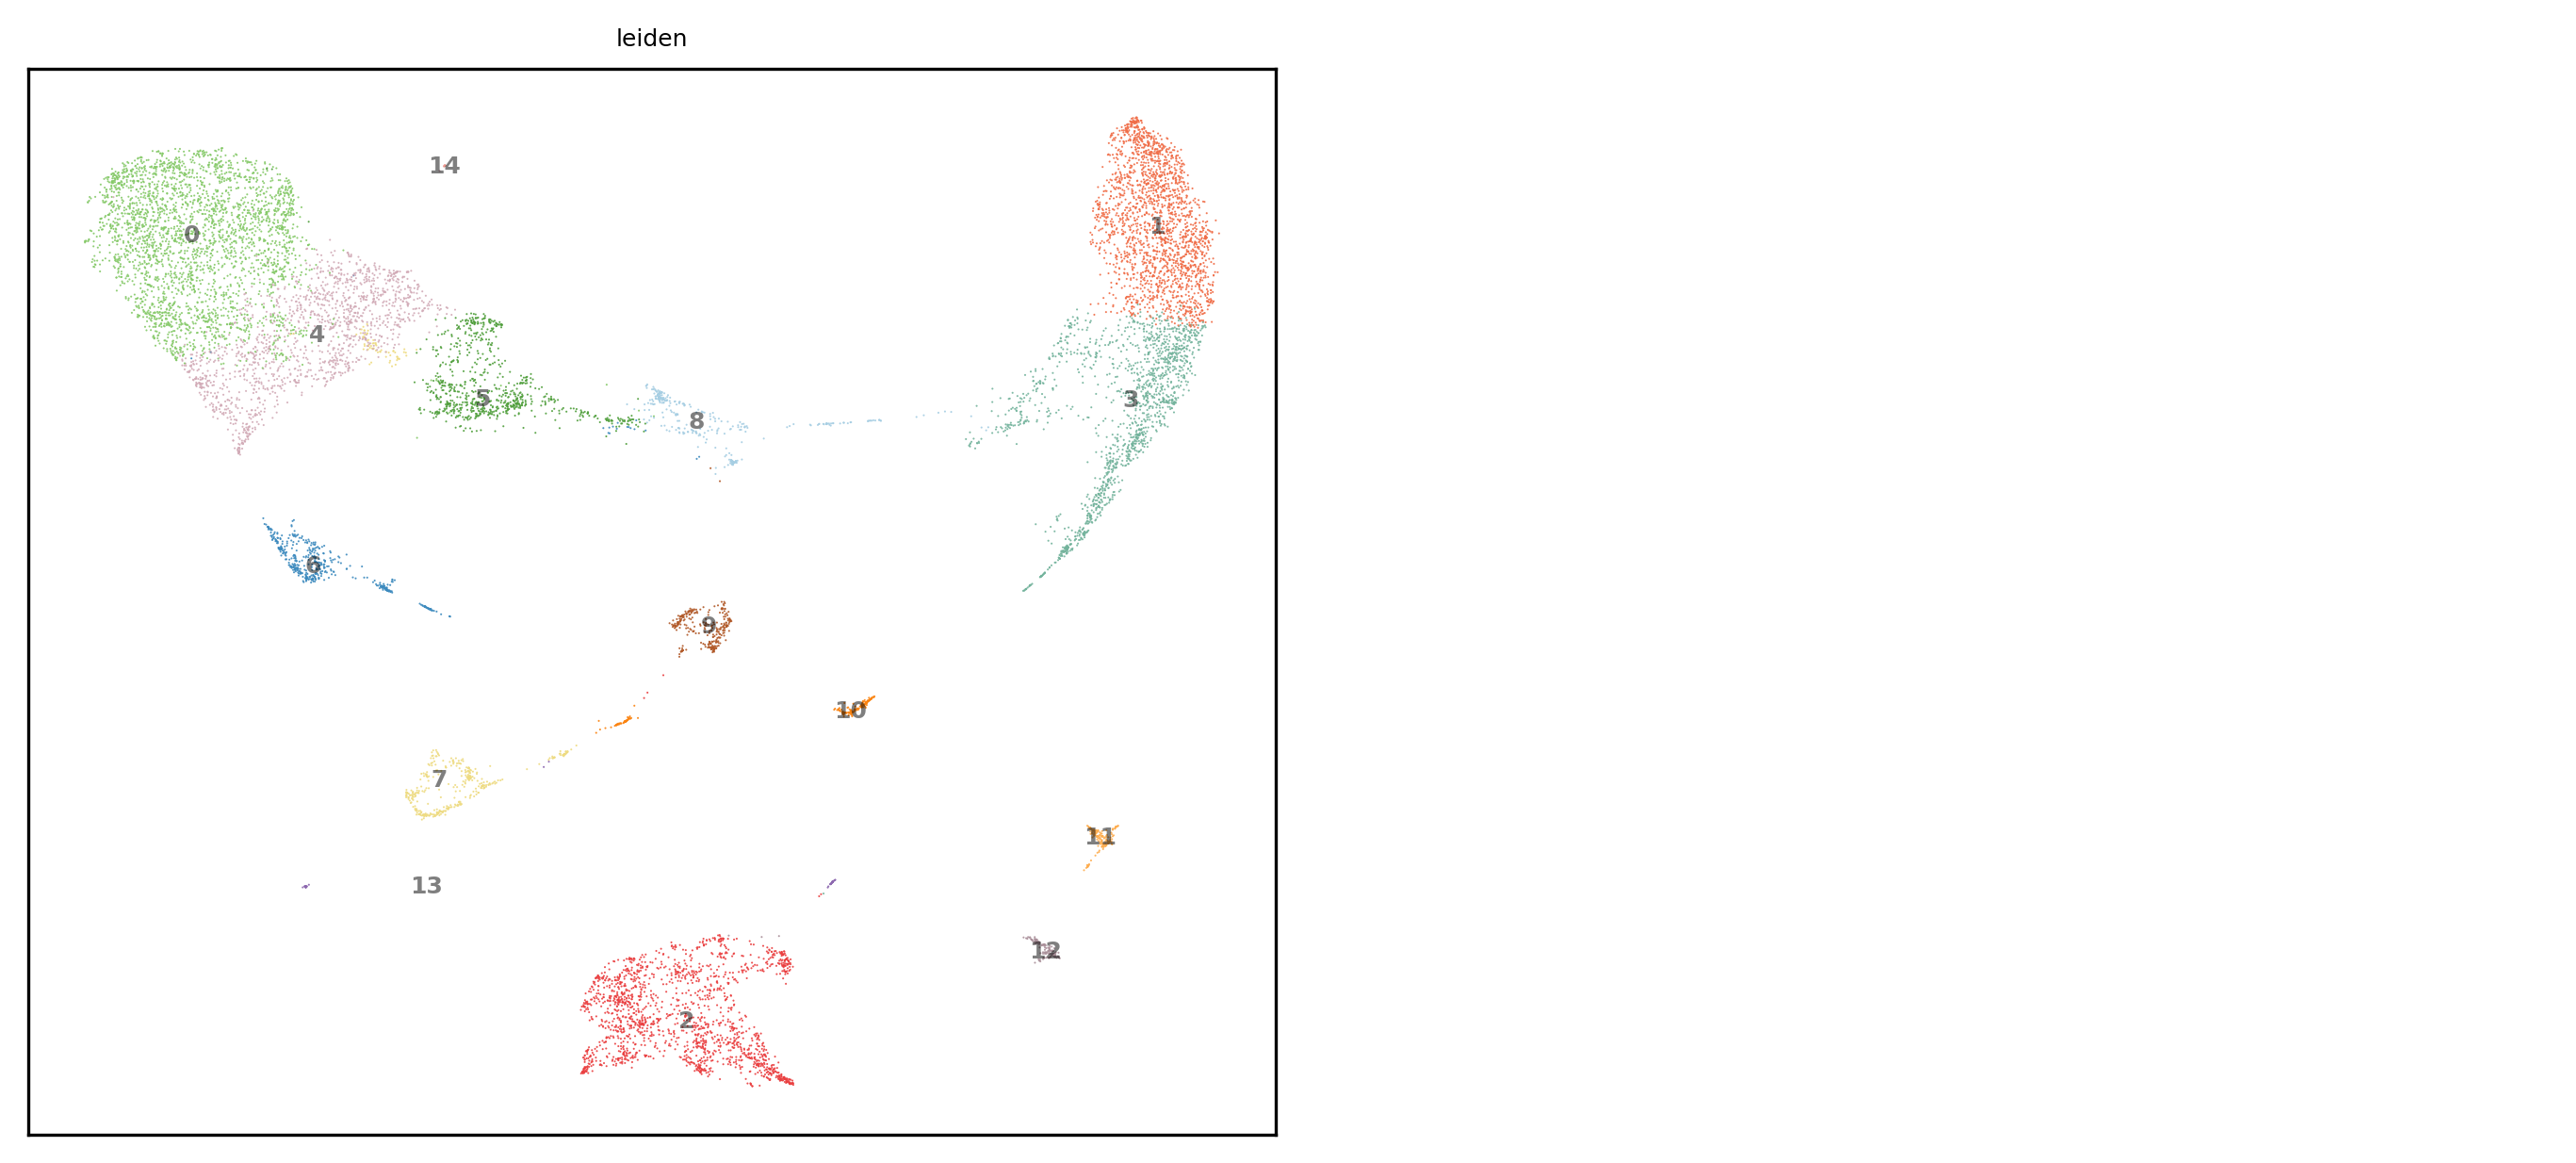

In [7]:
import concord as ccd
_, _, clus_pal = ccd.pl.get_color_mapping(p3_adata, 'leiden', pal='Paired', seed=1)
pal = {'leiden':clus_pal}
show_basis = f'X_umap'
show_cols = ['leiden']
ccd.pl.plot_embedding(
    p3_adata, show_basis, show_cols, figsize=(9,4), dpi=300, ncols=2,  font_size=6, point_size=1, legend_loc='on data',
    pal=pal,
    save_path=save_dir / f"p3_embeddings_{show_basis}_{file_suffix}.png"
)

In [8]:
import concord as ccd
cur_ccd = ccd.Concord(adata=p3_adata, 
                      latent_dim = n_latent,
                      save_dir=save_dir, # directory to save model checkpoints
                      inplace=False, # whether to modify adata in place
                      ) 

# Encode data, saving the latent embedding in adata.obsm['Concord']
output_key = 'Concord'
cur_ccd.encode_adata(input_layer_key='X', output_key=output_key, preprocess=False)
p3_adata.obsm = cur_ccd.adata.obsm.copy()
# Save the latent embedding to a file, so that it can be loaded later
ccd.ul.save_obsm_to_hdf5(cur_ccd.adata, save_dir / f"p3_obsm_{file_suffix}.h5")

Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.
Concord - WARNING - domain/batch information not found, all samples will be treated as from single domain/batch.


FAISS not found. Using sklearn for k-NN computation.
You specified p_intra_domain as 0.95 but you only have one domain. Resetting p_intra_domain to 1.0.


p_intra_knn: 0.3


Epoch 0 Training: 193it [00:07, 25.37it/s, loss=3.89]
Epoch 9 Training: 100%|██████████| 193/193 [00:07<00:00, 25.24it/s, loss=3.38]


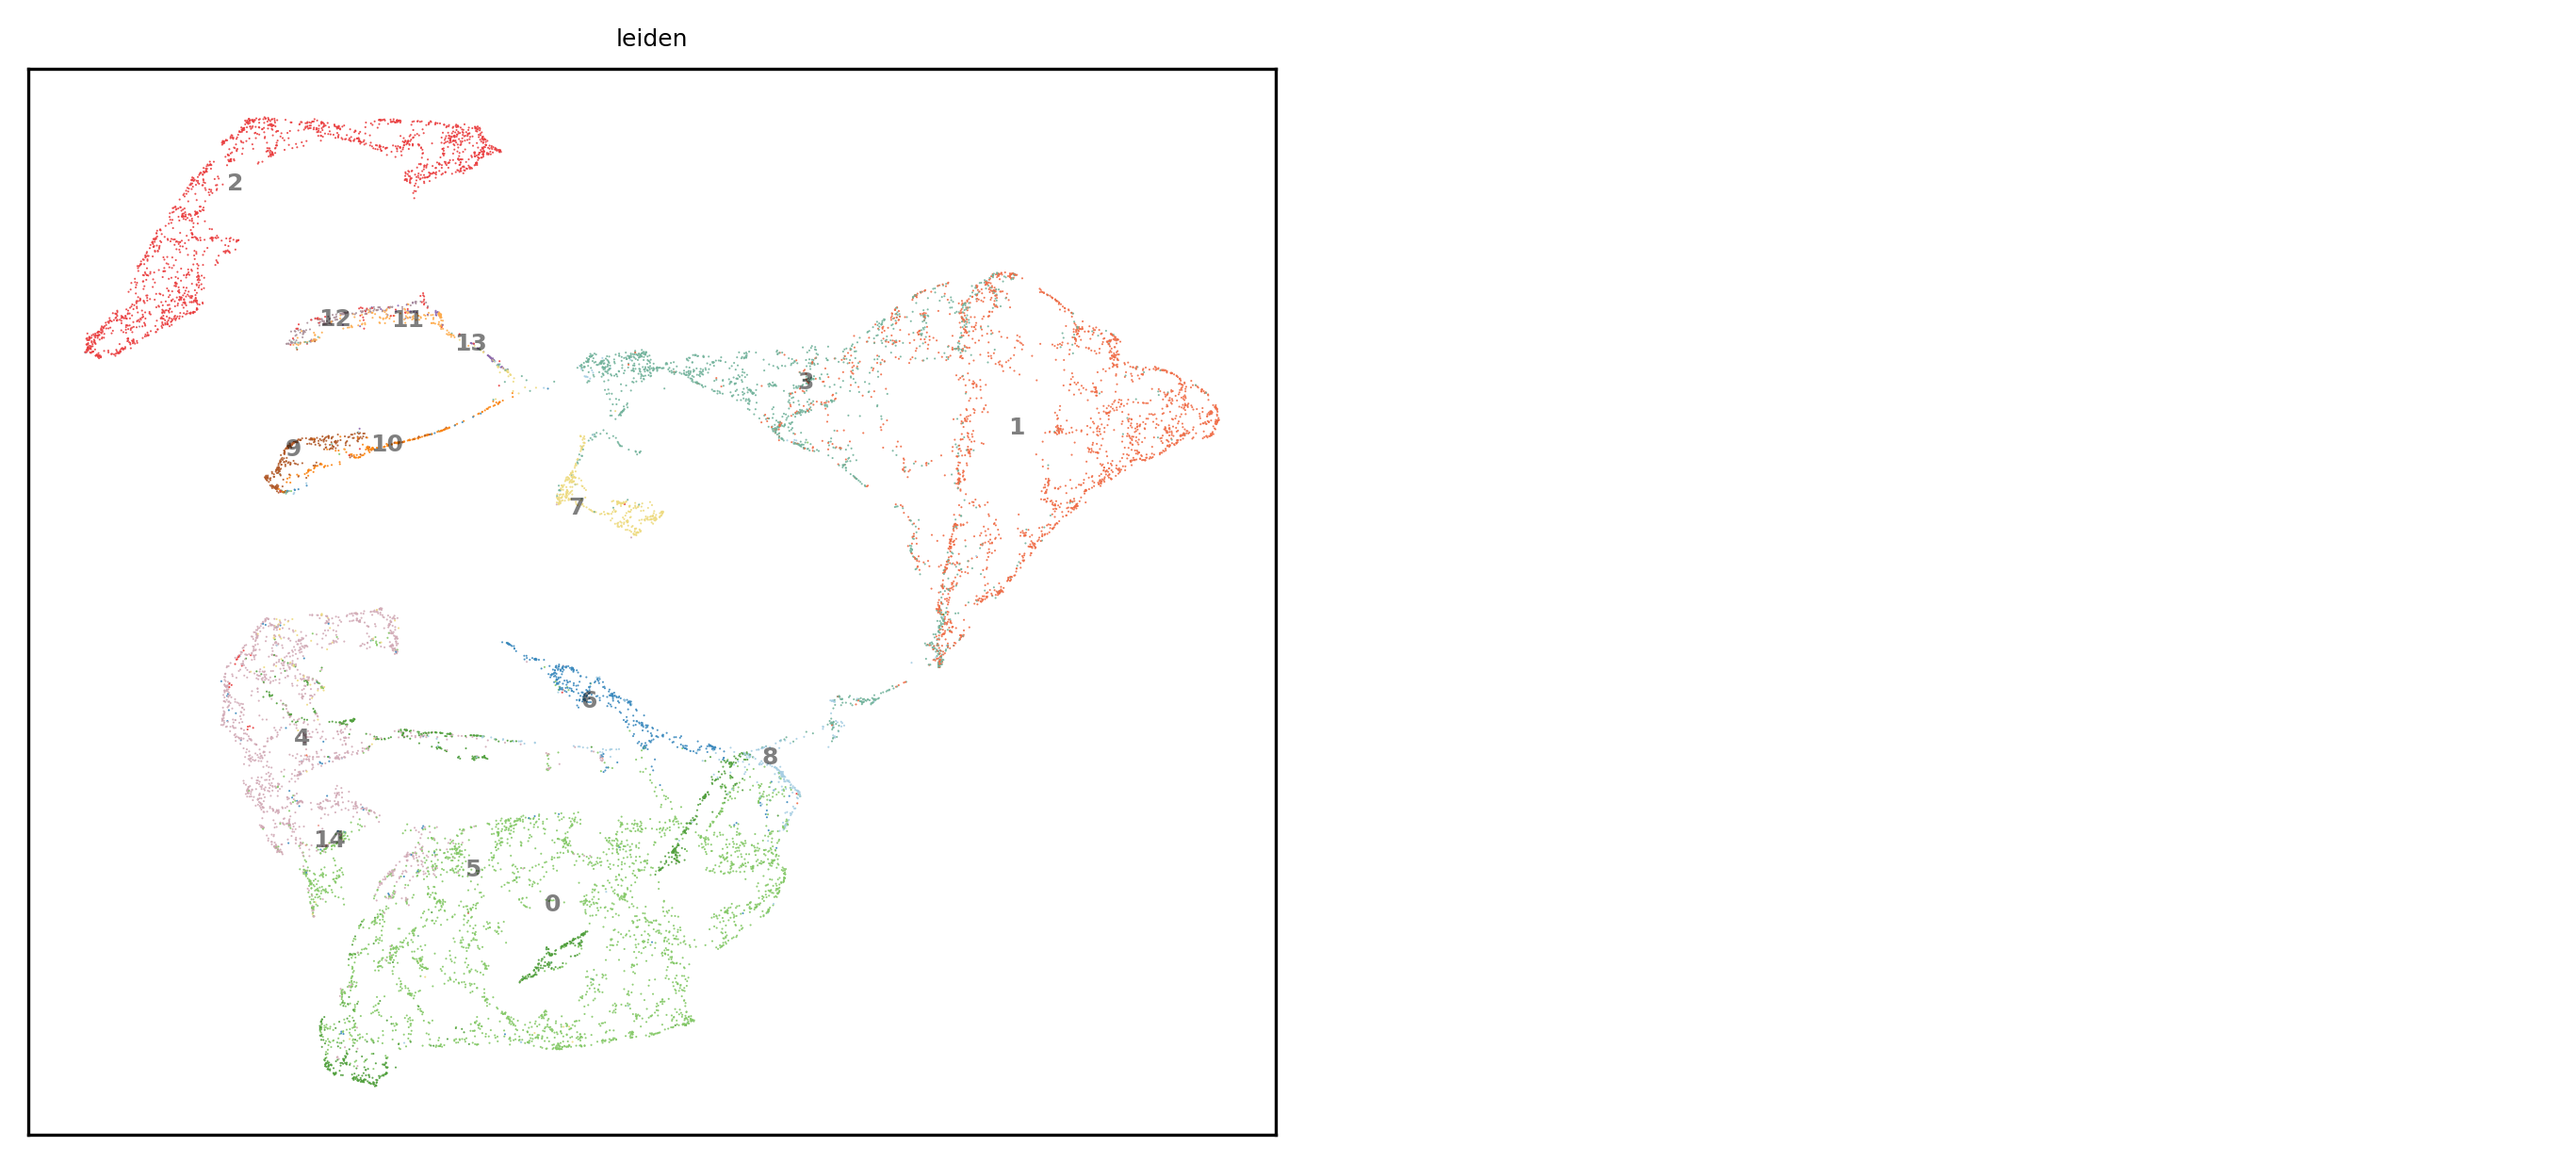

In [11]:
# compute umap
ccd.ul.run_umap(p3_adata, source_key=output_key, result_key=f'{output_key}_UMAP', n_components=2, n_neighbors=15, min_dist=0.1, metric='euclidean')
show_basis = f'{output_key}_UMAP'
show_cols = ['leiden']
ccd.pl.plot_embedding(
    p3_adata, show_basis, show_cols, figsize=(9,4), dpi=300, ncols=2, font_size=6, point_size=1, legend_loc='on data',
    pal=pal,
    save_path=save_dir / f"p3_embeddings_{show_basis}_{file_suffix}.png"
)

In [12]:
p3_adata.shape

(12388, 36601)

In [13]:
p3_adata.obs_names = "p3_" + p3_adata.obs_names.astype(str)
p3_adata.write_h5ad(data_dir / f"p3_adata_{file_suffix}.h5ad")
print(f"Saved p3_adata to {data_dir / f'p3_adata_{file_suffix}.h5ad'}")
ccd.ul.anndata_to_viscello(p3_adata, data_dir / f"cello_p3_{proj_name}_{file_suffix}", project_name = proj_name, organism='hsa')
print(f"Saved viscello to {data_dir / f'cello_p3_{proj_name}_{file_suffix}.h5ad'}")


Saved p3_adata to ../data/janesick_nature_comms_2023/p3_adata_Jun05-2123.h5ad
VisCello project created at ../data/janesick_nature_comms_2023/cello_p3_janesick_nc_2023_dev_Jun05-2123
Saved viscello to ../data/janesick_nature_comms_2023/cello_p3_janesick_nc_2023_dev_Jun05-2123.h5ad
